ref: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import julian as jl

import matplotlib.pyplot as plt
import matplotlib as mpl

import lxml.html
import requests
import datetime as dt

#from sec_edgar_downloader import Downloader
#from edgar import Company, XBRL, XBRLElement
from pandas import Series, DataFrame
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

register_matplotlib_converters()

In [ ]:
PAST_FUTURE_FACTOR = 4
FUTURE_PRED_DAYS = 365

tdFuturePrediction = dt.timedelta(days=FUTURE_PRED_DAYS)
tdPast = tdFuturePrediction * PAST_FUTURE_FACTOR
gIndex = 1

dtStartPeriod = dt.datetime(year=2008,month=1,day=1)
dtDataPeriod = dt.timedelta(days=365)
#dtEndPeriod = dtStartPeriod + dtDataPeriod
STOCKS_SCAN_PERIOD_YEARS = 10
STOCKS_SCAN_INTERVAL = '1mo' # Note options in function
PRED_ROLLING_MEAN_FROM_PAST_VAL_NUM = 12 # should be comparable with FUTURE_PRED_DAYS in units of STOCKS_SCAN_INTERVAL

STOCKS_SCAN_AVG_WINDOW = 3 * 1 # roling window in interval units
dfStockValuesLabled = DataFrame(columns=['StockName', 'StartTime', 'Period', 'StockAtStart', 'StockAtEnd','LableTime', 'LableValue'])

In [ ]:
tickerName = 'AAPL'
tickerData = yf.Ticker(tickerName)
dfStockData = tickerData.history(period=str(STOCKS_SCAN_PERIOD_YEARS)+"y", start=dtStartPeriod,interval=STOCKS_SCAN_INTERVAL)
dfStockData = dfStockData.dropna()
dtStartTmp = dtStartPeriod

In [ ]:
print(dfStockData)

              Open    High     Low   Close        Volume  Dividends  \
Date                                                                  
2008-01-01   24.71   24.83   15.64   16.79  8.793472e+09        0.0   
2008-02-01   16.89   16.94   14.32   15.50  6.216489e+09        0.0   
2008-03-01   15.43   18.07   14.63   17.79  5.731818e+09        0.0   
2008-04-01   18.14   22.32   17.81   21.57  5.696746e+09        0.0   
2008-05-01   21.70   23.84   21.33   23.41  4.647054e+09        0.0   
...            ...     ...     ...     ...           ...        ...   
2020-01-01  295.54  327.07  292.06  308.78  7.335926e+08        0.0   
2020-02-01  303.58  326.45  255.76  272.71  7.549628e+08        0.0   
2020-03-01  282.28  304.00  212.61  254.29  1.570018e+09        0.0   
2020-04-01  246.50  288.25  236.90  287.05  3.833065e+08        0.0   
2020-04-15  282.40  286.33  280.63  284.43  3.056240e+07        0.0   

            Stock Splits  
Date                      
2008-01-01           0

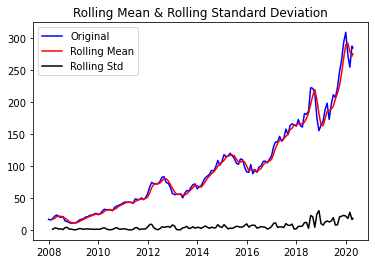

In [ ]:
dfStockDataClose = pd.DataFrame(dfStockData['Close'])

rolling_mean = dfStockDataClose.rolling(window = STOCKS_SCAN_AVG_WINDOW).mean()
rolling_std = dfStockDataClose.rolling(window = STOCKS_SCAN_AVG_WINDOW).std()
plt.plot(dfStockDataClose, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

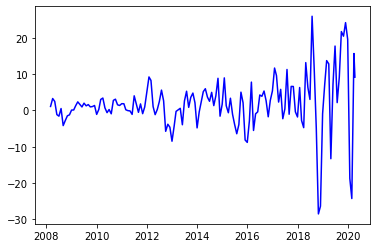

ADF Statistic: -4.698919702382727
p-value: 8.454688568940578e-05
Critical Values:
	1%: -3.4793722137854926
	5%: -2.8830370378332995
	10%: -2.578233635380623


In [ ]:
dfStockDataCloseSta = (dfStockDataClose - rolling_mean).dropna() #ORIGINAL WITH ROLLING MEAN
#dfStockDataCloseSta = (dfStockDataClose.shift() - dfStockDataClose).dropna()
plt.plot(dfStockDataCloseSta, color = 'blue', label = 'Mean Removed')
plt.show()

result = adfuller(dfStockDataCloseSta)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

c:\users\tom\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


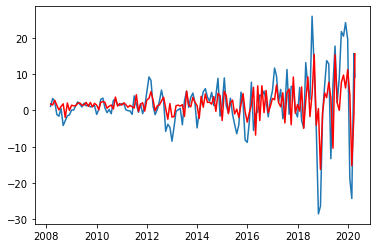

In [ ]:
decomposition = seasonal_decompose(dfStockDataCloseSta,period=1)


model = ARIMA(dfStockDataCloseSta, order=(2,0,1))
model_fit = model.fit(disp=-1)

plt.plot(dfStockDataCloseSta)
plt.plot(model_fit.fittedvalues, color='red')

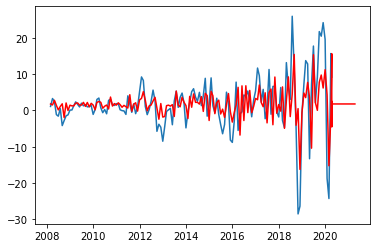

In [ ]:
forVals = pd.DataFrame(np.array(model_fit.forecast(steps=FUTURE_PRED_DAYS)[0]),pd.date_range(dt.datetime(year=2020,month=4,day=15), periods=FUTURE_PRED_DAYS).tolist(), columns=['Close'])
#forVals.index.name = "Date"
#forVals.name="Data"
fitVals = pd.DataFrame(model_fit.fittedvalues, columns=['Close'])

totalVal = pd.DataFrame(columns=['Close'])
totalVal=totalVal.append(fitVals)
totalVal=totalVal.append(forVals)

plt.plot(dfStockDataCloseSta)
plt.plot(totalVal, color='red')

In [ ]:
mean_for_fit = rolling_mean.iloc[-PRED_ROLLING_MEAN_FROM_PAST_VAL_NUM:]

mean_for_fit_y = mean_for_fit['Close'].tolist()
mean_for_fit_x = mean_for_fit.index.tolist()
mean_for_pred_x = forVals.index.tolist()
mean_for_pred_y = list();

for i in range(len(mean_for_fit_x)):
        mean_for_fit_x[i] = mean_for_fit_x[i].to_julian_date()


(slope,const)=np.polyfit(mean_for_fit_x,mean_for_fit_y,deg=1)

for i in range(len(mean_for_pred_x)):
    mean_for_pred_x[i] = mean_for_pred_x[i].to_julian_date()
    mean_for_pred_y.append(const + slope*mean_for_pred_x[i])

    
mean_total_x = mean_for_fit_x + mean_for_pred_x
mean_total_y = mean_for_fit_y + mean_for_pred_y


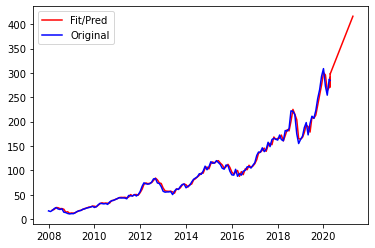

In [ ]:
mean_total_dates = list()

for i in range(len(mean_total_x)):
    mean_total_dates.append(jl.from_jd(mean_total_x[i], fmt='jd'))


dfMeanPred = pd.DataFrame(data=mean_total_y, index=mean_total_dates, columns=['Close'])

dfFitAbsVals = (fitVals + rolling_mean).dropna()
dfPredAbsVals = (forVals + dfMeanPred).dropna()

dfTotalStockWPred = dfFitAbsVals.append(dfPredAbsVals)


plt.plot(dfTotalStockWPred, color = 'red', label = 'Fit/Pred')
plt.plot(dfStockDataClose, color = 'blue', label = 'Original')

#plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
#plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
#for t in range(STOCKS_SCAN_PERIOD_YEARS):
#    dfPeriodStrockData = dfStockData.loc[dtStartTmp:(dtStartTmp+dtDataPeriod)]
#    if not (dfPeriodStrockData.empty):
#        openValueAtPeriodStart =  dfPeriodStrockData.iloc[1]['Open']
#        closeValueAtPeriodEnd = dfPeriodStrockData.iloc[dfPeriodStrockData.count()[0]-1]['Close']

#        lable = (closeValueAtPeriodEnd - openValueAtPeriodStart) / ((openValueAtPeriodStart+closeValueAtPeriodEnd)/2)
#        dfStockValuesLabled.loc[gIndex]=[tickerName, dtStartTmp, dtDataPeriod, openValueAtPeriodStart,closeValueAtPeriodEnd,dtStartTmp+dtDataPeriod+tdFuturePrediction, lable]
#        gIndex+=1

#    dtStartTmp += dtDataPeriod

NameError: name 'model_fit' is not defined